In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import VotingRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn import linear_model
from sklearn import ensemble
from sklearn import svm
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import optuna

import warnings
warnings.filterwarnings("ignore")

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [150]:
train = pd.read_csv('train.csv')
# test = pd.read_csv('train.csv')
# sub = pd.read_csv('sample_submission.csv')

In [151]:
train['Fuel Consumption City'].str.contains('AS').sum()

16090

In [140]:
train['Fuel Consumption City'].unique()

array(['8.64litersper100km', '27.27litersper100km', '0.17L/10km', ...,
       '38.92MPG(AS)', '43.52L/100km', '33.71L/100km'], dtype=object)

In [ ]:
def hapus_satuan(df, col):
    df[col] = df[col].str.replace(' ', '')
    df[col] = df[col].str.replace('litersper100km', '')
    df[col] = df[col].str.replace('L/100km', '')
    df[col] = df[col].str.replace('L/10km', '')
    df[col] = df[col].str.replace('MPG(AS)', '')
    df[col] = df[col].str.replace('km/L', '')
    df[col] = df[col].str.replace('kmperL', '')
    df[col] = df[col].str.replace('mpgImp.', '')
    df[col] = df[col].str.replace('not-available', '-1')
    df[col] = df[col].str.replace('zero', '0')
    df[col] = df[col].astype(float)

In [171]:
def change(df, col):
    df[col] = df[col].str.replace(' ', '')
    df[col] = df[col].str.replace('litersper100km', '')
    df[col] = df[col].str.replace('L/100km', '')
    df[col] = df[col].str.replace('L/10km', '*10')#'/10')
    df[col] = df[col].str.replace('MPG(AS)', '**(-1)* 235.21')
    df[col] = df[col].str.replace('km/L', '')#**(-1) /100')
    df[col] = df[col].str.replace('kmperL', '')#'**(-1) /100')
    df[col] = df[col].str.replace('mpgImp.', '**(-1)* 282.48')
    df[col] = df[col].str.replace('not-available', '-1')
    df[col] = df[col].str.replace('zero', '0')
    df[col] = df[col].fillna("-1")
    for idx in df.index:
        df.at[idx, col] = eval(df.at[idx, col])
    df[col] = df[col].astype(float)
    df[col].values[df[col] > 100] = np.nan
    df[col].values[df[col] < 0] = np.nan

In [173]:
def check_column(df, col, sat):
    temp = df
    temp[col] = temp[col].str.replace(' ', '')
    temp = temp[temp[col].str.contains(sat).replace(sat, '') == True]
    #temp[col] = temp[col].str.replace(sat, '')
    change(temp, col)
    print(temp[col].describe())
    sns.displot(temp, x=col, kind="kde")

count    16098.000000
mean        13.988849
std          9.854316
min          0.000000
25%          6.340000
50%         12.520000
75%         19.780000
max         74.900000
Name: Fuel Consumption City, dtype: float64
count    32975.000000
mean        14.135329
std          9.941118
min          0.000000
25%          6.430000
50%         12.740000
75%         20.005000
max         88.630000
Name: Fuel Consumption City, dtype: float64
count    16614.000000
mean        13.944529
std          9.836149
min          0.000000
25%          6.300000
50%         12.500000
75%         19.700000
max         78.000000
Name: Fuel Consumption City, dtype: float64
count    16090.000000
mean        14.088933
std          9.964810
min          0.000596
25%          6.433534
50%         12.686624
75%         19.945731
max         78.142857
Name: Fuel Consumption City, dtype: float64
count    15764.000000
mean        13.091125
std         14.813799
min          1.080000
25%          4.980000
50%       

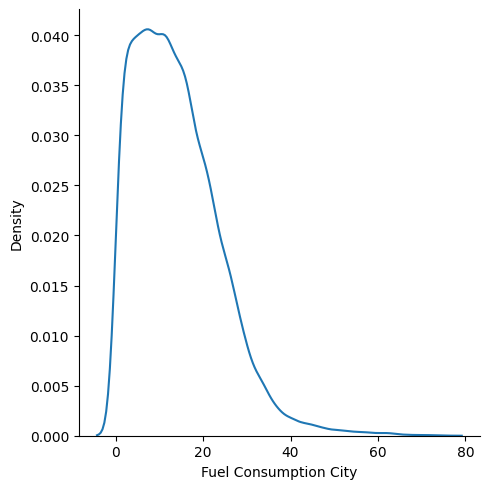

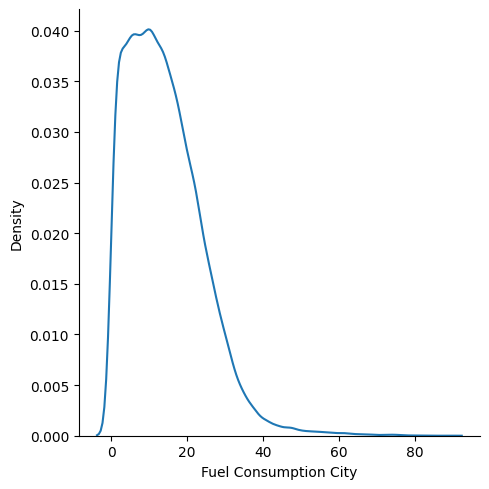

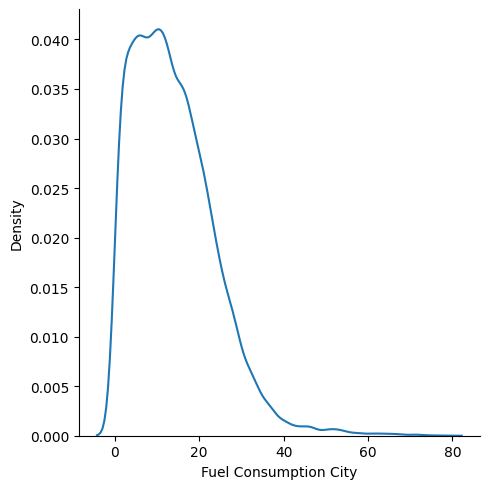

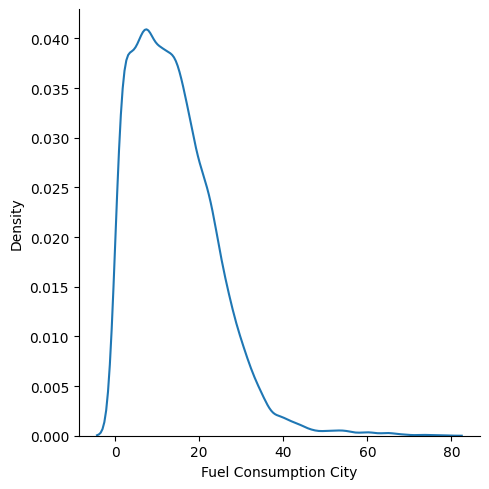

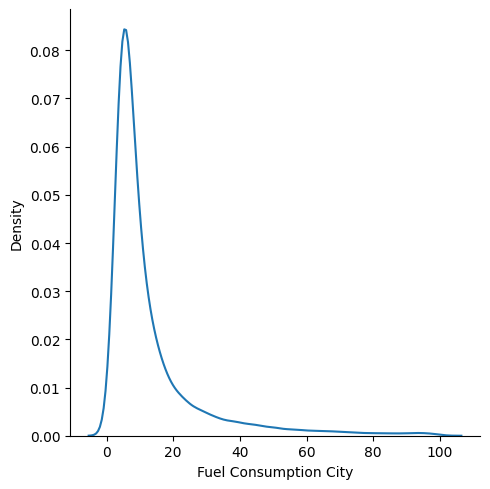

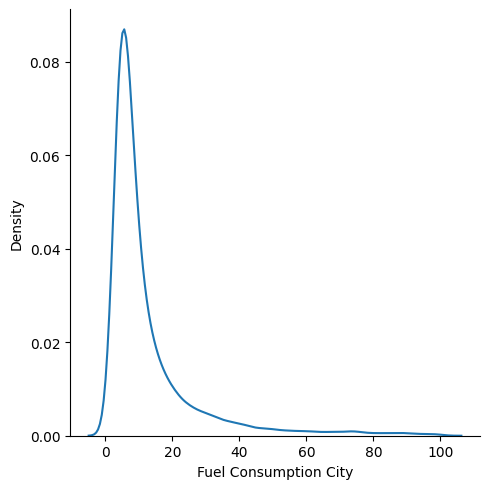

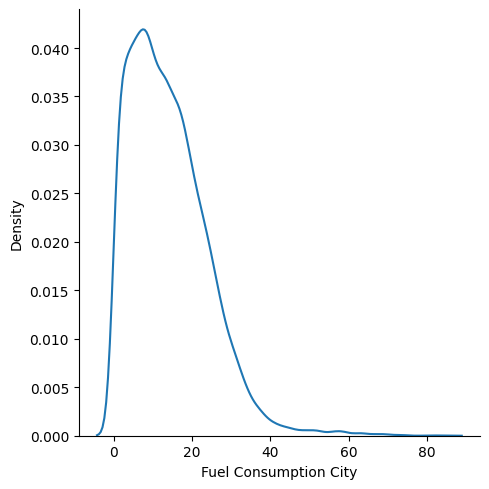

In [174]:
check_column(train, 'Fuel Consumption City', 'litersper100km')
check_column(train, 'Fuel Consumption City', 'L/100km')
check_column(train, 'Fuel Consumption City', 'L/10km')
check_column(train, 'Fuel Consumption City', 'MPG') # Hmm
check_column(train, 'Fuel Consumption City', 'km/L')
check_column(train, 'Fuel Consumption City', 'kmperL')
check_column(train, 'Fuel Consumption City', 'mpgImp.')

In [ ]:
check_column(train, 'Fuel Consumption Hwy', 'litersper100km')
check_column(train, 'Fuel Consumption Hwy', 'L/100km')
check_column(train, 'Fuel Consumption Hwy', 'L/10km')
check_column(train, 'Fuel Consumption Hwy', 'MPG(AS)') # Hmm
check_column(train, 'Fuel Consumption Hwy', 'km/L')
check_column(train, 'Fuel Consumption Hwy', 'kmperL')
check_column(train, 'Fuel Consumption Hwy', 'mpgImp.')

In [ ]:
check_column(train, 'Fuel Consumption Comb', 'litersper100km')
check_column(train, 'Fuel Consumption Comb', 'L/100km')
check_column(train, 'Fuel Consumption Comb', 'L/10km')
check_column(train, 'Fuel Consumption Comb', 'MPG(AS)') # Hmm
check_column(train, 'Fuel Consumption Comb', 'km/L')
check_column(train, 'Fuel Consumption Comb', 'kmperL')
check_column(train, 'Fuel Consumption Comb', 'mpgImp.')

In [50]:
train[(train['CO2 Emissions(g/km)'] < 100) & (train['Cylinders'] == 4)]['Cylinders'].describe()

count    1114.0
mean        4.0
std         0.0
min         4.0
25%         4.0
50%         4.0
75%         4.0
max         4.0
Name: Cylinders, dtype: float64

In [51]:
train[(train['CO2 Emissions(g/km)'] < 100)]['Cylinders'].describe()

count    1300.000000
mean        4.196154
std         0.951875
min        -1.000000
25%         4.000000
50%         4.000000
75%         4.000000
max        12.000000
Name: Cylinders, dtype: float64

In [19]:
train['CO2 Emissions(g/km)'].nunique()

4508

In [20]:
train['CO2 Emissions(g/km)'].unique()

array([306.        , 283.        , 329.        , ..., 463.29212734,
       294.86996342, 295.35139834])

In [29]:
train['Cylinders'].unique()

array(['6.0', nan, '4.0', '8.0', 'not-available', 'unestablished', '12.0',
       'unspecified', 'not-recorded', '3.0', '-1', 'missing', '5.0',
       'unknown', '10.0', 'na'], dtype=object)

In [45]:
def change_to_nan(df, col):
    df[col] = df[col].replace('not-available', np.nan)
    df[col] = df[col].replace('unestablished', np.nan)
    df[col] = df[col].replace('unspecified', np.nan)
    df[col] = df[col].replace('not-recorded', np.nan)
    df[col] = df[col].replace('missing', np.nan)
    df[col] = df[col].replace('unknown', np.nan)
    df[col] = df[col].replace('na', np.nan)
    df[col] = df[col].replace('-1', np.nan)

In [46]:
change_to_nan(train, 'Fuel Type')
change_to_nan(train, 'Vehicle Class')
change_to_nan(train, 'Engine Size(L)')
change_to_nan(train, 'Cylinders')
change_to_nan(train, 'Transmission')
change_to_nan(train, 'Fuel Type')

In [62]:
train[train['Fuel Type'].isnull()]

,Id,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,CO2 Emissions(g/km)
14,15,TOLVO,COMPACT,3.0,6.0,AS6,NaN,23.39litersper100km,17.53 mpg Imp.,4.97 km/L,248.000000
15,16,KIO,SUV - SMALL,2.4,4.0,NaN,NaN,25.96litersper100km,10.04 km per L,15.06 mpg Imp.,264.000000
46,47,TOYOTI,SUV - STANDARD,2.5,4.0,AV,NaN,7.37L/100km,6.53 liters per 100 km,6.99 liters per 100 km,152.000000
51,52,TOLVO,STATION WAGON - MID-SIZE,2.0,4.0,AS8,NaN,1.17L/10km,14.35 L/100 km,18.23 MPG (AS),209.000000
73,74,GONDA,SUV - SMALL,1.8,4.0,AV,NaN,2.58L/10km,35.44 mpg Imp.,13.22 MPG (AS),96.000000
...,...,...,...,...,...,...,...,...,...,...,...
137111,137112,CHEVO,PICKUP TRUCK - STANDARD,NaN,4.0,A8,NaN,13.97litersper100km,21.44 liters per 100 km,16.30 mpg Imp.,330.000000
137117,137118,TOYOTI,SUV - STANDARD,3.5,6.0,AS8,NaN,20.30L/100km,11.40 km per L,15.56 MPG (AS),264.000000
137127,137128,BMV,SUV - SMALL,2.0,NaN,NaN,NaN,35.27MPG(AS),49.65 MPG (AS),48.71 mpg Imp.,294.869963
137129,137130,FOLD,PICKUP TRUCK - STANDARD,3.0,6.0,AS10,NaN,43.52L/100km,35.02 mpg Imp.,10.25 mpg Imp.,260.000000


In [66]:
train.isnull().mean()

Id                       0.000000
Make                     0.000000
Vehicle Class            0.037421
Engine Size(L)           0.177431
Cylinders                0.144924
Transmission             0.076126
Fuel Type                0.054098
Fuel Consumption City    0.017661
Fuel Consumption Hwy     0.018725
Fuel Consumption Comb    0.018827
CO2 Emissions(g/km)      0.000000
dtype: float64

In [74]:
train.isnull().sum()

Id                           0
Make                         0
Vehicle Class             5132
Engine Size(L)           24333
Cylinders                19875
Transmission             10440
Fuel Type                 7419
Fuel Consumption City     2422
Fuel Consumption Hwy      2568
Fuel Consumption Comb     2582
CO2 Emissions(g/km)          0
dtype: int64

In [68]:
train['Vehicle Class'].mode()

0    SUV - SMALL
Name: Vehicle Class, dtype: object

In [86]:
def hapus_satuan(df, col):
    df[col] = df[col].str.replace(' ', '')
    df[col] = df[col].str.replace('litersper100km', '')
    df[col] = df[col].str.replace('L/100km', '')
    df[col] = df[col].str.replace('L/10km', '')
    df[col] = df[col].str.replace('MPG(AS)', '')
    df[col] = df[col].str.replace('km/L', '')
    df[col] = df[col].str.replace('kmperL', '')
    df[col] = df[col].str.replace('mpgImp.', '')
    df[col] = df[col].str.replace('not-available', '-1')
    df[col] = df[col].str.replace('zero', '0')
    df[col] = df[col].astype(float)

In [87]:
hapus_satuan(train, 'Fuel Consumption City')
hapus_satuan(train, 'Fuel Consumption Hwy')
hapus_satuan(train, 'Fuel Consumption Comb')

In [69]:
def plot_distribution(column):
    mean_co2 = train.groupby(
        column)[column].count().sort_values(ascending=False)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=mean_co2.index, y=mean_co2.values, palette='rocket')
    plt.xticks(rotation=90)
    plt.xlabel(column)
    plt.ylabel('CO2 Emissions(g/km)')
    plt.title(f'Average CO2 Emissions(g/km) by {column}')
    plt.show()

In [ ]:
fig, ax = plt.subplots(6, 3, figsize = (35, 65))
axe = ax.ravel()
for i, elm in enumerate(train['Vehicle Class'].unique()):
    train[train['Vehicle Class'] == elm]['CO2 Emissions(g/km)'].plot(kind='kde', ax=axe[i])
    train[train['Vehicle Class'].isnull()]['CO2 Emissions(g/km)'].plot(kind='kde', ax=axe[i])
    axe[i].set_title(elm)
lines, labels = ax.get_legend_handles_labels()
labels = ['SUV', 'NaN']
ax.legend(lines, labels, loc='best')
# add figure title
plt.title('Vehicle Class')

In [91]:
train['Vehicle Class'].mode()

0    SUV - SMALL
Name: Vehicle Class, dtype: object

In [110]:
def plot_kde(df, col):
    modus = df[train[col] == train[col].mode()[0]]['CO2 Emissions(g/km)']
    modus_nan = df[(train[col] == train[col].mode()[0]) | (train[col].isnull())]['CO2 Emissions(g/km)']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    modus.plot(kind='kde', ax=ax)
    modus_nan.plot(kind='kde', ax=ax)

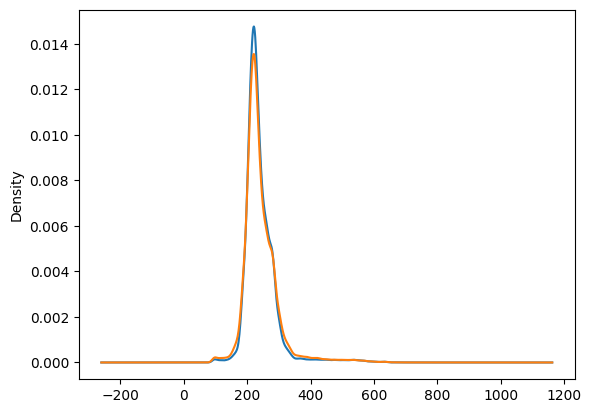

In [109]:
plot_kde(train, 'Vehicle Class')

In [101]:
train['Vehicle Class'].fillna('SUV - SMALL')

0         PICKUP TRUCK - STANDARD
1         PICKUP TRUCK - STANDARD
2                      SUBCOMPACT
3                     SUV - SMALL
4                     MINICOMPACT
                   ...           
137136                 SUBCOMPACT
137137      STATION WAGON - SMALL
137138                   MID-SIZE
137139                    COMPACT
137140                   MID-SIZE
Name: Vehicle Class, Length: 137141, dtype: object

In [104]:
train['Engine Size(L)']

array(['3.5', '5.3', '4.4', nan, '3.0', '1.8', '2.0', '3.6', '2.5', '2.4',
       '2.3', '1.4', '1.6', '5.0', '1.3', '6.2', '4.8', '2.7', '6.0',
       '3.2', '6.5', '5.7', '3.7', '1.2', '4.0', '3.3', '1.5', '5.2',
       '3.8', '2.8', '4.6', '6.4', '4.3', '6.6', '5.4', '1.0', '5.6',
       '5.8', '8.4', '3.4', '4.2', '6.8', '2.2'], dtype=object)

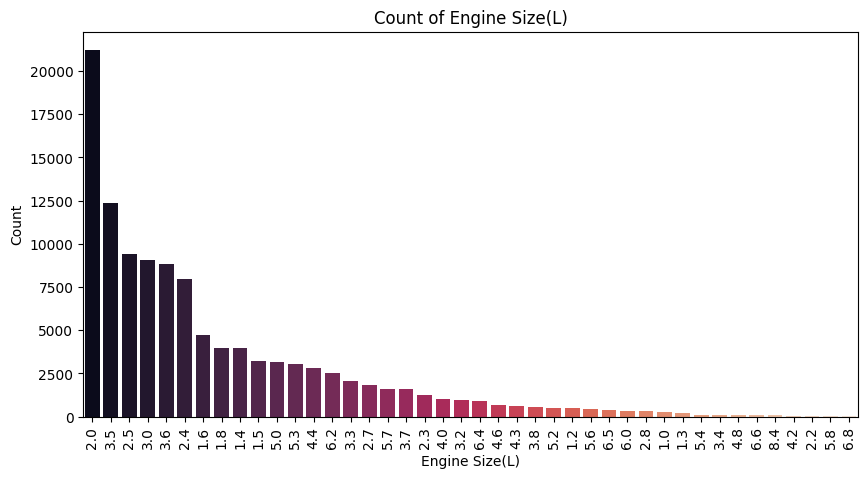

In [106]:
def plot_count(column):
    mean_co2 = train.groupby(
        column)['CO2 Emissions(g/km)'].count().sort_values(ascending=False)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=mean_co2.index, y=mean_co2.values, palette='rocket')
    plt.xticks(rotation=90)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'Count of {column}')
    plt.show()

plot_count('Engine Size(L)')

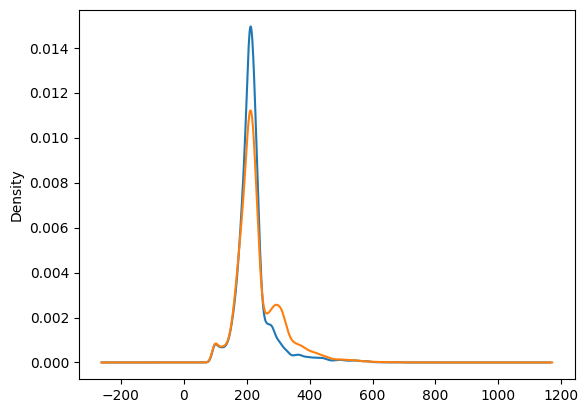

In [111]:
plot_kde(train, 'Engine Size(L)')